In [3]:
import lightgbm


import boruta

import sklearn.feature_selection as fs

import numpy as np

import fri
from sklearn.preprocessing import scale

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [333]:
def get_truth_AR(d, informative, redundant):
    truth = (
        [2] * (informative) + [1] * (redundant) + [0] * (d - (informative + redundant))
    )
    return truth


def get_truth(d, informative, redundant):
    truth = [True] * (informative + redundant) + [False] * (
        d - (informative + redundant)
    )
    return truth


from sklearn.metrics import precision_score, recall_score, f1_score


def get_scores(support, truth):
    return [
        (sc.__name__, sc(truth, support))
        for sc in [precision_score, recall_score, f1_score]
    ]


import sklearn.feature_selection as fs


def get_fs(estimator,X=None,y=None):
    fset = fs.SelectFromModel(prefit=True, estimator=estimator,threshold="mean").get_support()
    #fset = fs.RFECV(estimator=estimator,cv=3).fit(X,y).get_support()
    return fset


def RF(X, y, params=None):
    if params is None:
        lm = lightgbm.LGBMClassifier(
            max_depth=3, boosting_type="rf", bagging_fraction=0.632, bagging_freq=1,
            
        )
    else:
        lm = lightgbm.LGBMClassifier(**params)
    lm.fit(X, y)
    return lm


def get_MR(X, y, params=None):
    lm = RF(X, y, params)
    # todo: welcher score?
    score = lm.score(X, y)
    fset = get_fs(lm,X,y)
    fset = np.where(fset)
    return fset[0], score

def get_AR_params(X, y, params):
    tree_params = {k: v for k, v in params.items() if not k.startswith("b_")}
    boruta_params = {k[2:]: v for k, v in params.items() if k.startswith("b_")}

    lm = lightgbm.LGBMClassifier(**tree_params)
    feat_selector = BorutaPy(lm, verbose=0, random_state=1, **boruta_params)
    feat_selector.fit(X, y)

    fset = feat_selector.support_

    return fset

In [341]:
from sklearn.model_selection import ParameterGrid

best_params_rf = {
    "max_depth": [5],
    "boosting_type": ["rf"],
    "bagging_fraction": [0.632],
    "bagging_freq": [1],
    "feature_fraction": [0.1],
    "b_perc" : [100],
    "b_n_estimators":["auto"],
    "b_alpha":[0.01],
    "b_max_iter":[50],
    "importance_type":["gain"],
    }
best_params_rf = ParameterGrid(best_params_rf)[0]

In [342]:

best_params_boost = {
    "boosting_type": ["gbdt"],
    }
best_params_boost = ParameterGrid(best_params_boost)[0]

# Iterative check

In [343]:
from sklearn.model_selection import cross_val_score

In [344]:
def create_support_AR(d,S,W):
    sup = np.zeros(d)
    sup[S] = 2
    sup[W] = 1
    return sup.astype(int)

def cv_score(X,y,model,cv=20):
    return np.mean(cross_val_score(model,X,y,cv=cv))

def train_and_score(X,y,params=None):
    rf = RF(X,y,params)
    return cv_score(X,y,rf)

def score_with_feature_set(X,y,featureset:list,params=None):
    return train_and_score(X[:,featureset],y,params)


def sort_features(X,y, MR, AR,params_rf=None,params_boost=None):
    S = []
    W = list(np.setdiff1d(AR,MR))
    print(f"predetermined weakly {W}")
          
    score_on_MR = score_with_feature_set(X,y,MR,params_boost)
    score_on_AR = score_with_feature_set(X,y,AR,params_boost)
    MR_and_W =  np.union1d(MR,W)
    score_on_MR_and_W = score_with_feature_set(X,y,MR_and_W,params_boost)
    scores = {"MR":score_on_MR,"AR":score_on_AR,"MR+W":score_on_MR_and_W}
    for k,sc in scores.items():
        print(f"{k} has score {sc}")

    for f in MR:
        
        C = np.setdiff1d(MR,f) # Remove f from minimal set
        C = np.union1d(C,W) # Combine with weakly relevant features
        
        score_c = score_with_feature_set(X,y,C,params_boost)
        print(f"score without {f} is {score_c:.3}-> ",end="")

        if score_c < score_on_MR_and_W:
            print(f"S")
            S.append(f)
        else:
            print(f"W")
            W.append(f)
    return create_support_AR(X.shape[1],S,W)

def get_ar_classes(X,y,params_rf,params_boost):
    
    AR = np.where(get_AR_params(X,y,params_rf))[0]
    MR, score = get_MR(X,y,params_boost)

    print(f"Features from Boruta:\n {AR}")
    print(f"Features from Lightbgm:\n {MR}")
    
    return sort_features(X,y,MR,AR,params_rf,params_boost)

In [345]:
informative = 10
redundant = 4
d = 50

X,y = fri.genClassificationData(n_features=d,n_redundant=redundant
                                ,n_strel=informative, n_samples=400,random_state=123)
X = scale(X)

truth = get_truth(d, informative, redundant)
truth_AR = get_truth_AR(d, informative, redundant)

In [346]:
predict_AR = get_ar_classes(X,y,best_params_rf,best_params_boost)

Features from Boruta:
 [ 0  1  2  3  4  5  7  8  9 10 11 12]
Features from Lightbgm:
 [ 0  1  2  3  4  5  6  7  8  9 12 20 25]
predetermined weakly [10, 11]
MR has score 0.8606015037593986
AR has score 0.8583646616541353
MR+W has score 0.8658395989974939
score without 0 is 0.823-> S
score without 1 is 0.832-> S
score without 2 is 0.836-> S
score without 3 is 0.812-> S
score without 4 is 0.817-> S
score without 5 is 0.816-> S
score without 6 is 0.856-> S
score without 7 is 0.836-> S
score without 8 is 0.816-> S
score without 9 is 0.813-> S
score without 12 is 0.858-> S
score without 20 is 0.858-> S
score without 25 is 0.851-> S


0.25


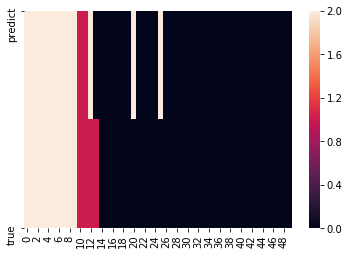

In [347]:
from scipy.spatial.distance import jaccard

jac = jaccard(predict_AR,truth_AR)
print(jac)

import seaborn as sns
%matplotlib inline
sns.heatmap(np.array([predict_AR,truth_AR]),yticklabels=["predict","true"])